# Thermal processing script
## Estimating log-linear models for thermal processing based on collected metadata

This first part of the script is used to estimate log-linear models for thermal processing based on collected metadata. The models are used to predict the kinetic parameters of Shiga-Toxin producing E.coli during thermal processing. The first chunk creates simple frequentist regressions and shows the secondary inactivation models. 

                              Model  Intercept     Slope  Data_Points  \
0          Model A: Liquid Products   8.600385 -0.140279          224   
1  Model B: High Acidic Fruit Juice   6.587751 -0.108324           58   

   Standard_Error_Regression    sigma2         z  
0                   0.441031  0.193636  7.128674  
1                   0.306660  0.092391  9.231569  


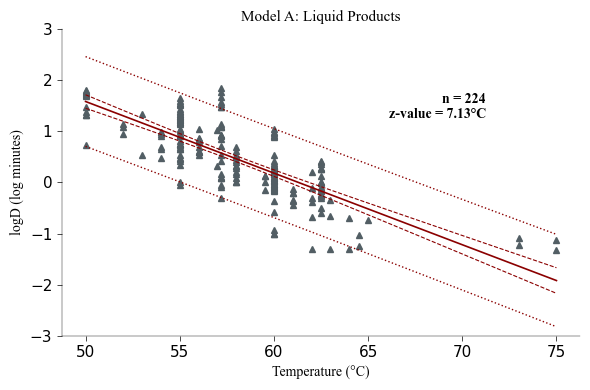

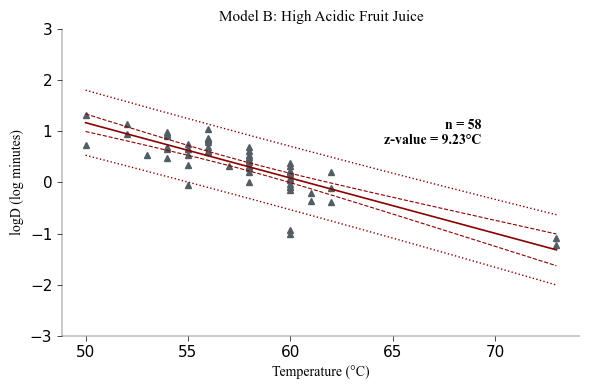

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

# Read data
file_path = "/Users/rickmannes/Documents/Msc. THESIS/QMRA (git)/RM_QMRA_Thesis/thesis/Inactivation_data_RM.xlsx"
tp_data = pd.read_excel(file_path, sheet_name="TP")

# ----------------------------------------------------
# STEP 1: Model fitting function (same as before)
# ----------------------------------------------------
def process_linear_model(data, model_name):
    model = smf.ols('logD ~ Temperature', data=data).fit()

    intercept = model.params['Intercept']
    slope = model.params['Temperature']
    n = data.shape[0]
    k = len(model.params)
    residuals = model.resid
    SER = np.sqrt(np.sum(residuals**2) / (n - k))
    sigma2 = np.var(residuals, ddof=1)
    z = -1 / slope

    regression_coefficients = pd.DataFrame({
        'Model': [model_name],
        'Intercept': [intercept],
        'Slope': [slope],
        'Data_Points': [n],
        'Standard_Error_Regression': [SER],
        'sigma2': [sigma2],
        'z': [z]
    })

    return {
        'original_data': data.copy(),
        'model': model,
        'regression_coefficients': regression_coefficients,
        'z_value': z
    }

# ----------------------------------------------------
# STEP 2: Data filtering and modeling
# ----------------------------------------------------
liquid_data = tp_data[tp_data['Item'] == "Liquid"]
high_acidic_juice_data = tp_data[
    (tp_data['Fruit juice'] == "Fruit juice") &
    (tp_data['Fruit juice acidity'] == "High acidic fruit juice")
]

results_lm_A = process_linear_model(liquid_data, "Model A: Liquid Products")
results_lm_C = process_linear_model(high_acidic_juice_data, "Model B: High Acidic Fruit Juice")

all_regressions_tp_lm = pd.concat([
    results_lm_A['regression_coefficients'],
    results_lm_C['regression_coefficients']
], ignore_index=True)

print(all_regressions_tp_lm)

# ----------------------------------------------------
# STEP 3: Improved plotting using smooth grid
# ----------------------------------------------------
def create_lm_regression_plot(data, model, z_value, model_name, y_range=(-3, 3)):
    fig, ax = plt.subplots(figsize=(6, 4))

    # Create smooth grid for predictions
    temp_grid = np.linspace(data['Temperature'].min(), data['Temperature'].max(), 100)
    new_data = pd.DataFrame({'Temperature': temp_grid})
    pred_summary = model.get_prediction(new_data).summary_frame(alpha=0.05)

    # Plot scatter of raw data
    ax.plot(
        data['Temperature'], data['logD'],
        linestyle='none', marker='^', color="#525e64", markersize=5, label='Observed'
    )

    # Plot regression line + intervals
    ax.plot(temp_grid, pred_summary['mean'], color="darkred", linewidth=1.2, label='Regression')
    ax.plot(temp_grid, pred_summary['mean_ci_lower'], '--', color="darkred", linewidth=0.8, label='95% CI')
    ax.plot(temp_grid, pred_summary['mean_ci_upper'], '--', color="darkred", linewidth=0.8)
    ax.plot(temp_grid, pred_summary['obs_ci_lower'], ':', color="darkred", linewidth=1.0, label='95% PI')
    ax.plot(temp_grid, pred_summary['obs_ci_upper'], ':', color="darkred", linewidth=1.0)

    # Annotations
    ax.text(
        0.95 * data['Temperature'].max(),
        0.95 * data['logD'].max(),
        f"n = {len(data)}\nz-value = {z_value:.2f}°C",
        ha='right', va='top',
        fontsize=10, fontweight='bold', family='Times New Roman'
    )

    # Styling
    ax.set_xlabel("Temperature (°C)", fontsize=10, family="Times New Roman")
    ax.set_ylabel("logD (log minutes)", fontsize=10, family="Times New Roman")
    ax.set_ylim(y_range)
    ax.tick_params(axis='both', labelsize=11)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(0.3)
    ax.spines['bottom'].set_linewidth(0.3)
    ax.tick_params(width=0.5)
    ax.set_facecolor('white')
    ax.grid(False)
    ax.set_title(model_name, fontsize=11, family="Times New Roman")

    plt.tight_layout()
    return fig, ax

# ----------------------------------------------------
# STEP 4: Plot both models
# ----------------------------------------------------
fig_lm_A, ax_lm_A = create_lm_regression_plot(
    results_lm_A['original_data'],
    results_lm_A['model'],
    results_lm_A['z_value'],
    "Model A: Liquid Products"
)

fig_lm_C, ax_lm_C = create_lm_regression_plot(
    results_lm_C['original_data'],
    results_lm_C['model'],
    results_lm_C['z_value'],
    "Model B: High Acidic Fruit Juice"
)

plt.show()

## Bayesian regression models
This next section creates the Bayesian regression models. It starts with defining the priors based on the frequentist regression coefficients. The priors are then used to create the Bayesian regression models. The Bayesian models then compares the prior knowledge with the data and provides posterior distributions of the kinetic parameters. The posterior distributions are then used to create the final model, which is used to predict the kinetic parameters of Shiga-Toxin producing E.coli during thermal processing. A markov chain Monte Carlo (MCMC) method is used to sample from the posterior distribution, which allows for the estimation of the kinetic parameters with full variability and uncertainty. The final output is a set of posterior distributions for the kinetic parameters (slope, intercept and standard deviation). The MCMC uses the No-U-Turn Sampler (NUTS) algorithm, which is a variant of the Hamiltonian Monte Carlo (HMC) algorithm. This approach uses four chains to sample from the posterior distributions, and convergence is checked using the Gelman-Rubin statistic. The final output is a set of posterior distributions for the kinetic parameters, which can be used to predict the kinetic parameters of Shiga-Toxin producing E.coli during thermal processing.

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, Temperature, sigma]
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, Temperature, sigma]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 7 seconds.
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...


Finished sampling for Model A: Liquid Products


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, Temperature, sigma]
NUTS: [Intercept, Temperature, sigma]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 6 seconds.


Finished sampling for Model B: High Acidic Fruit Juice
               mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd   ess_bulk  \
Intercept    8.6081  0.2485  8.1416   9.0750     0.0035   0.0026  5174.5016   
Temperature -0.1404  0.0043 -0.1483  -0.1323     0.0001   0.0000  5172.3177   
sigma        0.4422  0.0210  0.4028   0.4816     0.0003   0.0002  5970.1300   

              ess_tail   r_hat  
Intercept    5333.8899  1.0009  
Temperature  5495.3217  1.0010  
sigma        6027.0106  1.0004  
               mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd   ess_bulk  \
Intercept    6.5831  0.3286  5.9859   7.2086     0.0048   0.0037  4681.9406   
Temperature -0.1082  0.0057 -0.1189  -0.0978     0.0001   0.0001  4679.6902   
sigma        0.3090  0.0292  0.2550   0.3629     0.0004   0.0003  6683.1001   

              ess_tail   r_hat  
Intercept    5094.2461  1.0010  
Temperature  5325.0948  1.0009  
sigma        5946.1729  1.0013  


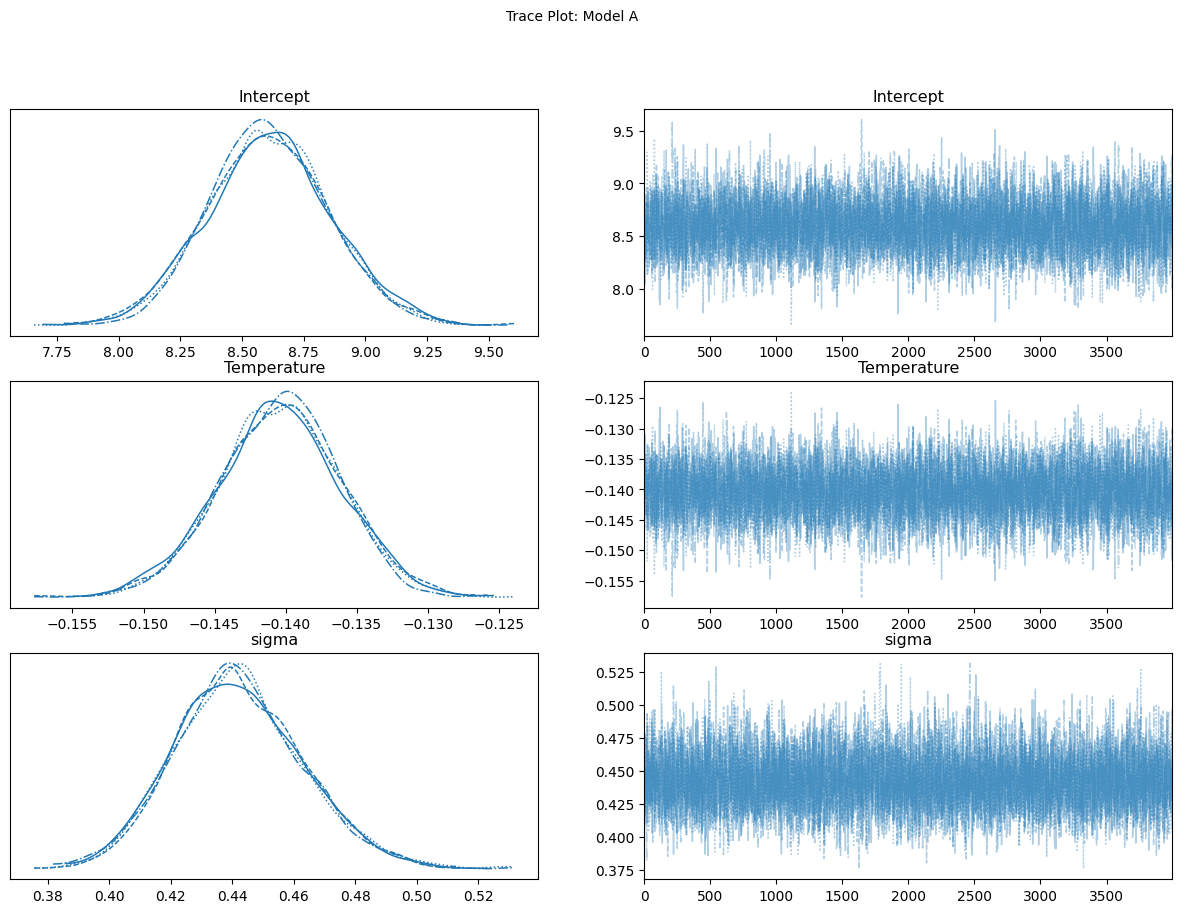

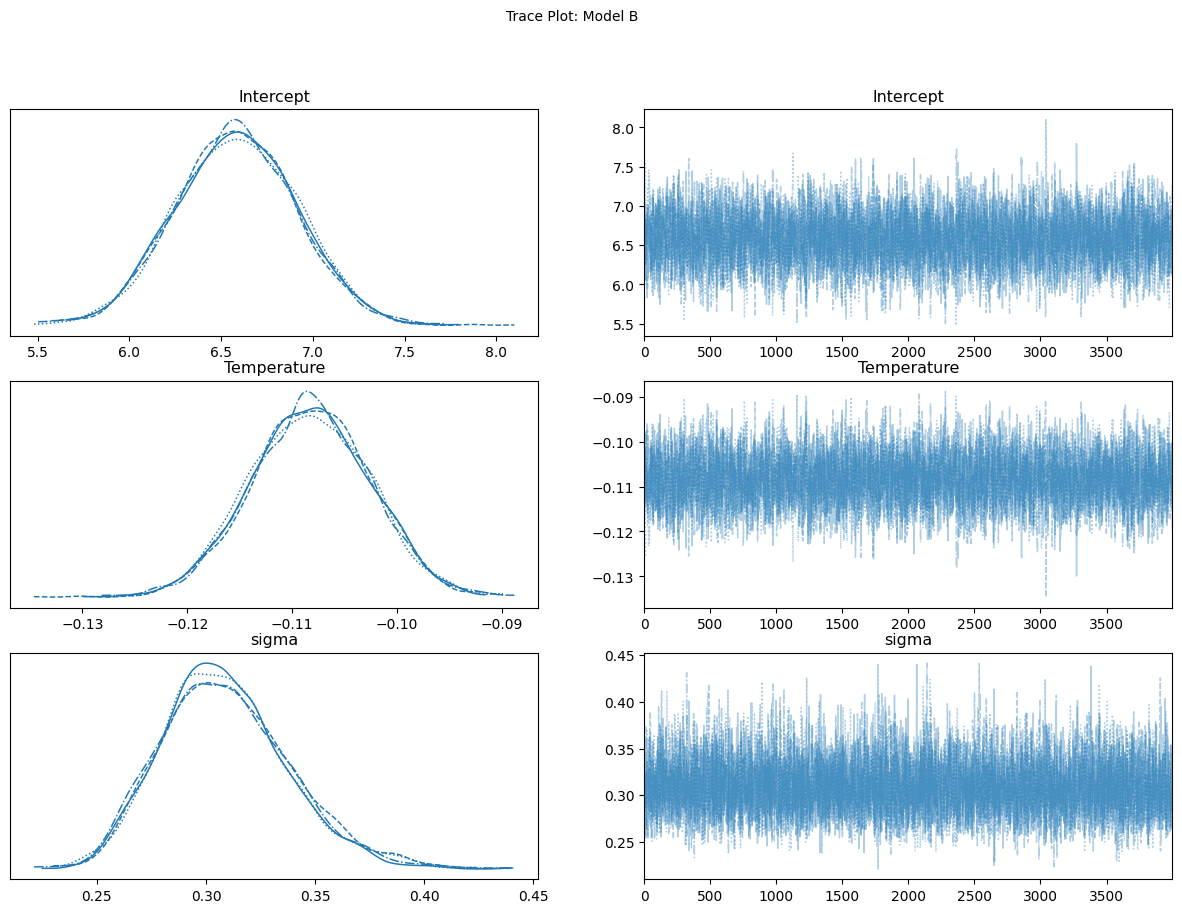

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import pymc as pm
import arviz as az
import patsy

# ---------------------------------------------------------
# 1. Load and filter data
# ---------------------------------------------------------
# Read data
file_path = "/Users/rickmannes/Documents/Msc. THESIS/QMRA (git)/RM_QMRA_Thesis/thesis/Inactivation_data_RM.xlsx"
tp_data = pd.read_excel(file_path, sheet_name="TP")

data_A = tp_data[tp_data['Item'] == "Liquid"].copy()
data_C = tp_data[
    (tp_data['Fruit juice'] == "Fruit juice") &
    (tp_data['Fruit juice acidity'] == "High acidic fruit juice")
].copy()

# ---------------------------------------------------------
# 2. Estimate frequentist-based priors
# ---------------------------------------------------------
def estimate_fixed_effect_priors(data):
    model = smf.ols('logD ~ Temperature', data=data).fit()
    return {
        'beta_0': {'mean': model.params['Intercept'], 'std': model.bse['Intercept']},
        'beta_1': {'mean': model.params['Temperature'], 'std': model.bse['Temperature']},
        'sigma': {'scale': model.mse_resid ** 0.5}
    }

priors_A = estimate_fixed_effect_priors(data_A)
priors_C = estimate_fixed_effect_priors(data_C)

# ---------------------------------------------------------
# 3. Build and run Bayesian model
# ---------------------------------------------------------
def build_bayesian_model(data, priors, model_name="Model"):
    y, X = patsy.dmatrices('logD ~ Temperature', data, return_type='dataframe')
    x_temp = X['Temperature'].values
    y_obs = y['logD'].values

    with pm.Model() as model:
        # Priors
        beta_0 = pm.Normal("Intercept", mu=priors['beta_0']['mean'], sigma=priors['beta_0']['std'])
        beta_1 = pm.Normal("Temperature", mu=priors['beta_1']['mean'], sigma=priors['beta_1']['std'])
        sigma = pm.HalfNormal("sigma", sigma=priors['sigma']['scale'])

        # Regression model
        mu = beta_0 + beta_1 * x_temp
        logD = pm.Normal("logD", mu=mu, sigma=sigma, observed=y_obs)

        # Sampling
        trace = pm.sample(
            draws=4000,
            tune=2000,
            chains=4,
            target_accept=0.95,
            return_inferencedata=True,
            progressbar=True
        )

    print(f"Finished sampling for {model_name}")
    return model, trace

# Run both models
bayesian_model_A, trace_A = build_bayesian_model(data_A, priors_A, "Model A: Liquid Products")
bayesian_model_C, trace_C = build_bayesian_model(data_C, priors_C, "Model B: High Acidic Fruit Juice")

# ---------------------------------------------------------
# 4. Posterior summaries
# ---------------------------------------------------------
print(az.summary(trace_A, round_to=4))
print(az.summary(trace_C, round_to=4))


# ---------------------------------------------------------
# 6. Trace plots
# ---------------------------------------------------------
az.plot_trace(trace_A, figsize=(15, 10))
plt.suptitle("Trace Plot: Model A", fontsize=10)
plt.show()

az.plot_trace(trace_C, figsize=(15, 10))
plt.suptitle("Trace Plot: Model B", fontsize=10)
plt.show()

## Visualization of regression models (Deterministic + Stochastic + Bayesian)
The next section uses both the frequentist regression model (deterministic + stochastic with 95% prediction interval) and uses the Bayesian posterior distributions to create all possible regression lines to predict logD as kinetic parameter. This short section basically visualizes the approach of the three different modelling types, adding more complexity respectively. 

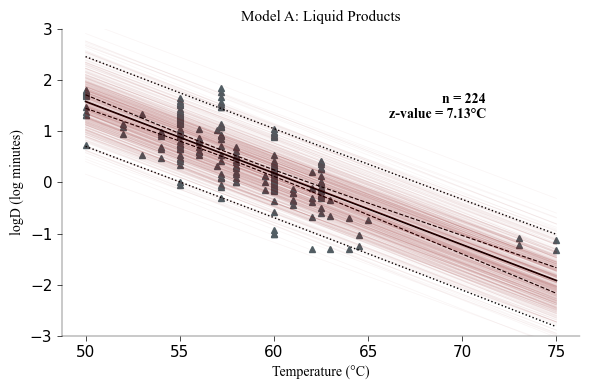

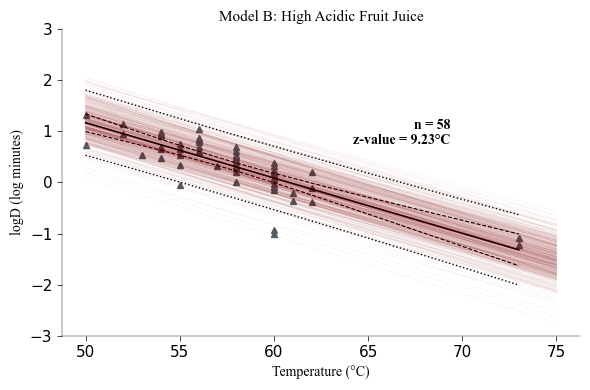

In [30]:
# --------------------------------------------------------
# Bayesian regression lines with shifted intercepts (Models A and C)
# --------------------------------------------------------
import numpy as np
import pandas as pd

def generate_bayesian_regression_lines(posterior, model_label, temp_min, temp_max, n_samples=500, n_points=200):
    """
    Generate Bayesian regression lines with intercept shifting from posterior samples.
    """
    temp_range = np.linspace(temp_min, temp_max, n_points)
    
    # Stack posterior samples
    intercepts = posterior["Intercept"].stack(sample=("chain", "draw")).values
    slopes = posterior["Temperature"].stack(sample=("chain", "draw")).values
    sigmas = posterior["sigma"].stack(sample=("chain", "draw")).values

    # Random subset of samples
    idx = np.random.choice(len(intercepts), size=n_samples, replace=False)
    intercepts_sampled = intercepts[idx]
    slopes_sampled = slopes[idx]
    sigmas_sampled = sigmas[idx]

    # Generate lines with shifted intercepts
    all_lines = []

    for i in range(n_samples):
        shift = np.random.normal(loc=0, scale=sigmas_sampled[i])
        intercept_shifted = intercepts_sampled[i] + shift
        slope = slopes_sampled[i]

        df_line = pd.DataFrame({
            "Temperature": temp_range,
            "logD": intercept_shifted + slope * temp_range,
            "Sample": f"{model_label}_{i}"
        })
        all_lines.append(df_line)

    return pd.concat(all_lines, ignore_index=True)

# Define global temperature range based on full dataset
temp_min = tp_data['Temperature'].min()
temp_max = tp_data['Temperature'].max()

# Generate lines for both models
bayes_lines_A = generate_bayesian_regression_lines(trace_A.posterior, "A", temp_min, temp_max)
bayes_lines_C = generate_bayesian_regression_lines(trace_C.posterior, "C", temp_min, temp_max)

import matplotlib.pyplot as plt

def plot_bayesian_with_frequentist(data, model, z_value, model_name, bayes_lines_df, y_range=(-3, 3)):
    fig, ax = plt.subplots(figsize=(6, 4))

    # Create smooth grid for prediction intervals
    temp_grid = np.linspace(data['Temperature'].min(), data['Temperature'].max(), 200)
    new_data = pd.DataFrame({'Temperature': temp_grid})
    pred_summary = model.get_prediction(new_data).summary_frame(alpha=0.05)

    # --- Raw observed data points ---
    ax.plot(
        data['Temperature'], data['logD'],
        linestyle='none', marker='^', color="#525e64",
        markersize=5, label="Observed"
    )

    # --- Frequentist regression line and intervals ---
    ax.plot(temp_grid, pred_summary['mean'], color="black", linewidth=1.2, label="Frequentist regression")
    ax.plot(temp_grid, pred_summary['mean_ci_lower'], '--', color="black", linewidth=0.8, label="95% CI")
    ax.plot(temp_grid, pred_summary['mean_ci_upper'], '--', color="black", linewidth=0.8)
    ax.plot(temp_grid, pred_summary['obs_ci_lower'], ':', color="black", linewidth=1.0, label="95% PI")
    ax.plot(temp_grid, pred_summary['obs_ci_upper'], ':', color="black", linewidth=1.0)

    # --- Bayesian regression lines (many thin red lines) ---
    for sample_id, df_group in bayes_lines_df.groupby("Sample"):
        ax.plot(df_group['Temperature'], df_group['logD'],
                color="darkred", alpha=0.04, linewidth=0.6)

    # --- Annotations ---
    ax.text(
        0.95 * data['Temperature'].max(),
        0.95 * data['logD'].max(),
        f"n = {len(data)}\nz-value = {z_value:.2f}°C",
        ha='right', va='top',
        fontsize=10, fontweight='bold', family='Times New Roman'
    )

    # --- Styling ---
    ax.set_xlabel("Temperature (°C)", fontsize=10, family="Times New Roman")
    ax.set_ylabel("logD (log minutes)", fontsize=10, family="Times New Roman")
    ax.set_ylim(y_range)
    ax.tick_params(axis='both', labelsize=11)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(0.3)
    ax.spines['bottom'].set_linewidth(0.3)
    ax.tick_params(width=0.5)
    ax.set_facecolor('white')
    ax.grid(False)
    ax.set_title(model_name, fontsize=11, family="Times New Roman")

    plt.tight_layout()
    return fig, ax

# ----------------------
# Plot Model A
# ----------------------
fig_bayes_A, ax_bayes_A = plot_bayesian_with_frequentist(
    results_lm_A['original_data'],
    results_lm_A['model'],
    results_lm_A['z_value'],
    "Model A: Liquid Products",
    bayes_lines_A
)

# ----------------------
# Plot Model B
# ----------------------
fig_bayes_C, ax_bayes_C = plot_bayesian_with_frequentist(
    results_lm_C['original_data'],
    results_lm_C['model'],
    results_lm_C['z_value'],
    "Model B: High Acidic Fruit Juice",
    bayes_lines_C
)

plt.show()

## Quantitative Microbial Risk Assessment (QMRA) framework
This approach is using Monte Carlo simulations with 1 million iterations to estimate the risk of illness from Shiga-Toxin producing E.coli in food products after thermal processing by taking random draws from defined input distributions. 

Now, the predicted (variability in) the kinetic parameter logD (at a certain temperature input) can be used in the QMRA. This code is basically the core of the project, as it brings together the different technologies. The framework is built in such a way that it can be used for themal processing, but also for high pressure processing and pulsed electric fields. In the first part, we define our input parameters, described as the process parameters (processing time and temperature), but also the serving size, prevalence of contamination and the distribution of an initial concentration of pathogenic cells. These data is based on factual numbers and real-world assumptions, all being explained in the methodology of the thesis. The same goes for the demographic/consumption data. 

Then the QMRA function is defined, starting with extracting the kinetic model parameters and uses the Bigelow secondary inactivation model to estimate the kinetic parameters based on the process input. Then, these (variable) parameters will be used in the primary inactivation model to estimate the number of surviving cells. An important note here is that the variability in inactivation kinetics is applied here, using the three different modelling approaches. The surviving cells will be converted into a dose, using the variable serving size, after which a probability of illness could be calculated using a dose-response model. 



In [48]:
import numpy as np
import pandas as pd

# ---------------------------------------------------------
# Constants and input distributions
# ---------------------------------------------------------
n_iterations = 1_000_000
np.random.seed(42)

# Temperature (normally distributed around 72°C)
Temperature_dist = np.random.normal(loc=72, scale=0.1, size=n_iterations)

# Time (normally 0.5 min with 0.1 min std)
time_dist_tp = np.random.normal(loc=0.5, scale=0.1, size=n_iterations)

# Serving size (ml)
serving_size_dist = np.random.normal(loc=125, scale=22, size=n_iterations)

# Prevalence
prevalence = 0.0013

# Custom PERT function
def rpert(n, min_val, mode, max_val, lamb=4):
    alpha = 1 + lamb * (mode - min_val) / (max_val - min_val)
    beta = 1 + lamb * (max_val - mode) / (max_val - min_val)
    return min_val + (max_val - min_val) * np.random.beta(alpha, beta, size=n)

# Initial concentration logN0
logN0_dist = rpert(n_iterations, min_val=-1.4, mode=-1.2, max_val=-0.5, lamb=4)

# Dose-response parameters
r_strachan = 0.00208

# Population stats
population = 446_000_000
adults, teenagers, children = 0.586, 0.052, 0.149
consumption = 15_400  # ml/person/year

pop_adults = population * adults
pop_teen = population * teenagers
pop_child = population * children

annual_servings_adults = (consumption / 150) * pop_adults
annual_servings_teen = (consumption / 117) * pop_teen
annual_servings_child = (consumption / 108) * pop_child
european_servings = annual_servings_adults + annual_servings_teen + annual_servings_child

# ----------------------------------------------------
# Define all_regressions_tp_lm from results_lm_A and results_lm_C
# ----------------------------------------------------
all_regressions_tp_lm = pd.concat([
    results_lm_A['regression_coefficients'],
    results_lm_C['regression_coefficients']
], ignore_index=True)

# ---------------------------------------------------------
# QMRA Simulation Function
# ---------------------------------------------------------
def simulate_qmra(regression_row, posterior_samples, model_name):
    intercept_lm = regression_row['Intercept'].values[0]
    slope_lm = regression_row['Slope'].values[0]
    ser_lm = regression_row['Standard_Error_Regression'].values[0]

    intercept_bayes = np.random.choice(posterior_samples['Intercept'], size=n_iterations, replace=True)
    slope_bayes = np.random.choice(posterior_samples['Temperature'], size=n_iterations, replace=True)
    sigma_bayes = np.random.choice(posterior_samples['sigma'], size=n_iterations, replace=True)
    residual_shift = np.random.normal(0, sigma_bayes)

    # Simulate logD for each approach
    logD_deterministic = intercept_lm + slope_lm * Temperature_dist
    logD_stochastic = logD_deterministic + np.random.normal(0, ser_lm, n_iterations)
    logD_bayesian = intercept_bayes + slope_bayes * Temperature_dist + residual_shift

    all_iterations = []

    results = []

    for scenario, logD in zip(
        ["Linear model (Deterministic)", "Linear model (Stochastic)", "Bayesian model (Probabilistic)"],
        [logD_deterministic, logD_stochastic, logD_bayesian]
    ):
        D = 10**logD
        N0 = 10**logN0_dist
        logNt = logN0_dist - (time_dist_tp / D)
        Nt = 10**logNt
        Reduction = np.log10(N0 / Nt)
        Dose = serving_size_dist * Nt
        prob_ill = np.maximum(1 - np.exp(-r_strachan * Dose), np.finfo(float).eps)
        risk_serving = prevalence * prob_ill
        cases_binom = np.random.binomial(1, prob_ill)

        # Save iteration-level data
        iter_df = pd.DataFrame({
            "Model": model_name,
            "Scenario": scenario,
            "Temperature": Temperature_dist,
            "Time": time_dist_tp,
            "Serving_size": serving_size_dist,
            "logN0": logN0_dist,
            "N0": N0,           
            "logD": logD,
            "D": D,
            "logNt": logNt,
            "Nt": Nt,
            "Reduction": Reduction,
            "Dose": Dose,
            "Probability_Illness": prob_ill,
            "Risk_per_Serving": risk_serving,
            "Ill_binomial": cases_binom
        })

        all_iterations.append(iter_df)

        # Save summary stats
        summary = {
            "Model": model_name,
            "Scenario": scenario,
            "Mean_reduction": np.mean(Reduction),
            "Reduction_overall": -np.log10(np.mean(Nt) / np.mean(N0)),
            "P2.5_Reduction": np.quantile(Reduction, 0.025),
            "P50_Reduction": np.quantile(Reduction, 0.5),
            "P97.5_Reduction": np.quantile(Reduction, 0.975),
            "P99_Reduction": np.maximum(np.quantile(Reduction, 0.99), np.finfo(float).eps),
            "Dose": np.mean(Nt) * np.mean(serving_size_dist),
            "Mean_logD": np.mean(logD),
            "SD_logD": np.std(logD),
            "P2.5_logD": np.quantile(logD, 0.025),
            "P50_logD": np.quantile(logD, 0.5),
            "P97.5_logD": np.quantile(logD, 0.975),
            "P99_logD": np.maximum(np.quantile(logD, 0.99), np.finfo(float).eps),
            "Probability_of_Illness": np.mean(prob_ill),
            "Prob_overall": 1 - np.exp(-r_strachan * (np.mean(Nt) * np.mean(serving_size_dist))),
            "Risk_per_Serving": np.mean(risk_serving),
            "Sum_trials": np.sum(cases_binom),
            "Cases per million servings": np.sum(cases_binom) * prevalence,
            "Annual cases EU": round((np.sum(cases_binom) * prevalence) * european_servings / n_iterations),
            "Cases_EU_average": round(np.mean(risk_serving) * european_servings),
            "Cases_EU_overall": round((1 - np.exp(-r_strachan * (np.mean(Nt) * np.mean(serving_size_dist)))) * prevalence * european_servings),
            "Total_servings": european_servings,
            "Cases_perc": ((np.sum(cases_binom) * prevalence) * european_servings / n_iterations) / european_servings * 100
        }

        results.append(summary)

    return pd.DataFrame(results), pd.concat(all_iterations, ignore_index=True)

In [49]:
# ---------------------------------------------------------
# Extract posterior samples for both models
# ---------------------------------------------------------
posterior_A = trace_A.posterior[['Intercept', 'Temperature', 'sigma']].stack(draws=("chain", "draw")).to_dataframe()
posterior_C = trace_C.posterior[['Intercept', 'Temperature', 'sigma']].stack(draws=("chain", "draw")).to_dataframe()

summary_A, iter_A = simulate_qmra(
    all_regressions_tp_lm[all_regressions_tp_lm['Model'] == 'Model A: Liquid Products'],
    posterior_A,
    "Model A: Liquid Products"
)

summary_C, iter_C = simulate_qmra(
    all_regressions_tp_lm[all_regressions_tp_lm['Model'] == 'Model B: High Acidic Fruit Juice'],
    posterior_C,
    "Model B: High Acidic Fruit Juice"
)

# Combine summaries and all iterations
all_summary_tp = pd.concat([summary_A, summary_C], ignore_index=True)
all_iterations_tp = pd.concat([iter_A, iter_C], ignore_index=True)

/var/folders/kn/y01l9gy569n9xw0md1_jsd480000gn/T/ipykernel_12095/20330990.py:86: RuntimeWarning: divide by zero encountered in divide
  Reduction = np.log10(N0 / Nt)
/var/folders/kn/y01l9gy569n9xw0md1_jsd480000gn/T/ipykernel_12095/20330990.py:86: RuntimeWarning: overflow encountered in divide
  Reduction = np.log10(N0 / Nt)
/Users/rickmannes/.virtualenvs/thesis/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/rickmannes/.virtualenvs/thesis/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


In [50]:
print(all_summary_tp)

                              Model                        Scenario  \
0          Model A: Liquid Products    Linear model (Deterministic)   
1          Model A: Liquid Products       Linear model (Stochastic)   
2          Model A: Liquid Products  Bayesian model (Probabilistic)   
3  Model B: High Acidic Fruit Juice    Linear model (Deterministic)   
4  Model B: High Acidic Fruit Juice       Linear model (Stochastic)   
5  Model B: High Acidic Fruit Juice  Bayesian model (Probabilistic)   

   Mean_reduction  Reduction_overall  P2.5_Reduction  P50_Reduction  \
0       15.806143           6.553853        9.566961      15.792588   
1             inf           2.775676        2.005428      15.480809   
2             inf           2.091306        1.027063      15.487817   
3        8.140313           5.141675        4.935882       8.136683   
4       10.451025           2.809324        1.866909       7.984715   
5             inf           1.594113        0.492398       7.939131   

   P

In [ ]:
print(all_iterations_tp)

## Replication & Convergence check
The next section is used to create replicates of the QMRA framekwork, which uses Monte Carlo simulations. The intention is to check for convergence between the different replictates, which is done by comparing the coefficients of variation (CV) between the different replicates. The CV is calculated for each replicate and then compared to the CV of the first replicate. If the CV of the first replicate is lower than the CV of the other replicates, it is assumed that the model has converged. This is done to quantify the between-replicate variability and to check if the model has converged. The most important outcome of the QMRA (being the estimated illness cases) are then plotted for each model and scenario, which is used in the thesis presentation. In the report, the numbers will be used in a table. 

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

n_chains = 5

# -------------------------------
# Convergence Simulation
# -------------------------------
def run_qmra_chains(reg_row, posterior, model_name):
    records = []
    for chain in range(1, n_chains + 1):
        np.random.seed(100 + chain)

        # Distributions
        Temperature_dist = np.random.normal(loc=72, scale=0.1, size=n_iterations)
        time_dist_tp = np.random.normal(loc=0.5, scale=0.1, size=n_iterations)
        serving_size_dist = np.random.normal(loc=125, scale=22, size=n_iterations)
        logN0_dist = rpert(n_iterations, min_val=-1.4, mode=-1.2, max_val=-0.5, lamb=4)

        # Regression and posterior
        intercept_lm = reg_row['Intercept']
        slope_lm = reg_row['Slope']
        ser_lm = reg_row['Standard_Error_Regression']

        intercept_bayes = np.random.choice(posterior['Intercept'], size=n_iterations)
        slope_bayes = np.random.choice(posterior['Temperature'], size=n_iterations)
        sigma_bayes = np.random.choice(posterior['sigma'], size=n_iterations)
        residual_shift = np.random.normal(0, sigma_bayes)

        logD_deterministic = intercept_lm + slope_lm * Temperature_dist
        logD_stochastic = logD_deterministic + np.random.normal(0, ser_lm, n_iterations)
        logD_bayesian = intercept_bayes + slope_bayes * Temperature_dist + residual_shift

        for scenario, logD in zip(
            ["Deterministic", "Stochastic", "Bayesian"],
            [logD_deterministic, logD_stochastic, logD_bayesian]
        ):
            D = 10**logD
            N0 = 10**logN0_dist
            Nt = 10**(logN0_dist - (time_dist_tp / D))
            Dose = Nt * serving_size_dist
            prob_ill = np.maximum(1 - np.exp(-r_strachan * Dose), np.finfo(float).eps)
            cases_binom = np.random.binomial(1, prob_ill)
            total_cases = np.sum(cases_binom)
            annual_cases = round((total_cases * prevalence) * european_servings / n_iterations)

            records.append({
                "Model": model_name,
                "Scenario": scenario,
                "Chain": chain,
                "Annual_Cases_EU": annual_cases
            })
    return pd.DataFrame(records)

# Replace with your loaded data
reg_A = all_regressions_tp_lm.iloc[0]
reg_C = all_regressions_tp_lm.iloc[1]

df_conv_A = run_qmra_chains(reg_A, posterior_A, "Model A: Liquid Products")
df_conv_C = run_qmra_chains(reg_C, posterior_C, "Model B: High Acidic Fruit Juice")

df_convergence = pd.concat([df_conv_A, df_conv_C], ignore_index=True)


--- Convergence Summary (Mean, SD, CV) ---
                              Model       Scenario     Mean           SD  \
0          Model A: Liquid Products       Bayesian   8657.6   513.590596   
1          Model A: Liquid Products  Deterministic     10.2    22.807893   
2          Model A: Liquid Products     Stochastic   1739.8   289.560356   
3  Model B: High Acidic Fruit Juice       Bayesian  27324.6  1022.078422   
4  Model B: High Acidic Fruit Juice  Deterministic     30.6    45.615787   
5  Model B: High Acidic Fruit Juice     Stochastic   1627.0   235.592869   

         CV  
0  0.053060  
1  2.000000  
2  0.148862  
3  0.033456  
4  1.333333  
5  0.129515  

--- Kruskal-Wallis Test Results (p-values) ---
Model A: Liquid Products | Bayesian: p = 0.4060
Model A: Liquid Products | Deterministic: p = 0.4060
Model A: Liquid Products | Stochastic: p = 0.4060
Model B: High Acidic Fruit Juice | Bayesian: p = 0.4060
Model B: High Acidic Fruit Juice | Deterministic: p = 0.4060
Model B: 

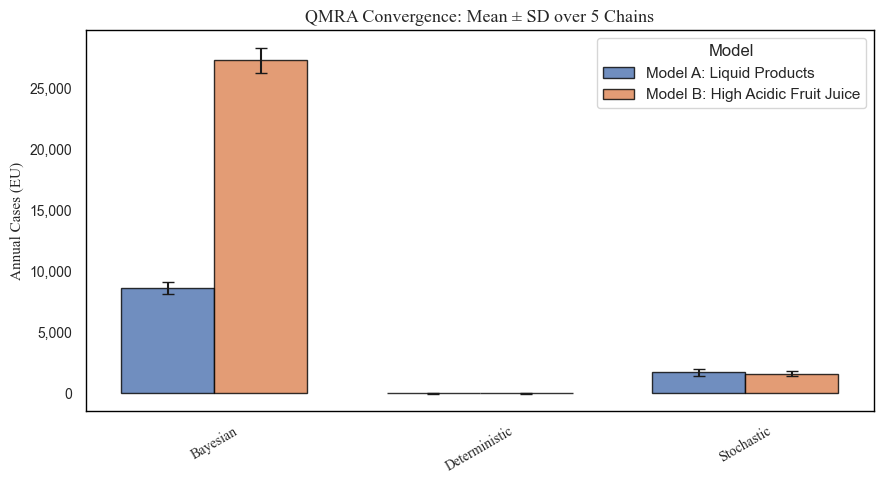

In [60]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import variation, kruskal

# --- Calculate mean, SD, and CV correctly ---
summary_stats = (
    df_convergence
    .groupby(['Model', 'Scenario'])
    .agg({
        'Annual_Cases_EU': ['mean', 'std', lambda x: variation(x, nan_policy='omit')]
    })
    .reset_index()
)
summary_stats.columns = ['Model', 'Scenario', 'Mean', 'SD', 'CV']

print("\n--- Convergence Summary (Mean, SD, CV) ---")
print(summary_stats)

# --- Kruskal-Wallis Test per group ---
print("\n--- Kruskal-Wallis Test Results (p-values) ---")
for (model, scenario), group in df_convergence.groupby(['Model', 'Scenario']):
    stat, p = kruskal(*[grp["Annual_Cases_EU"].values for _, grp in group.groupby("Chain")])
    print(f"{model} | {scenario}: p = {p:.4f}")

# --- Plot using matplotlib only ---
models = summary_stats['Model'].unique()
scenarios = summary_stats['Scenario'].unique()

x = np.arange(len(scenarios))
width = 0.35  # bar width

fig, ax = plt.subplots(figsize=(9, 5))

for i, model in enumerate(models):
    model_data = summary_stats[summary_stats['Model'] == model]
    offset = (i - len(models)/2) * width + width/2
    xpos = x + offset

    ax.bar(
        xpos,
        model_data['Mean'],
        yerr=model_data['SD'],
        width=width,
        label=model,
        capsize=4,
        edgecolor='black',
        alpha=0.8
    )

# Format axes
ax.set_xticks(x)
ax.set_xticklabels(scenarios, rotation=30, fontsize=10, family="Times New Roman")
ax.set_ylabel("Annual Cases (EU)", fontsize=11, family="Times New Roman")
ax.set_title("QMRA Convergence: Mean ± SD over 5 Chains", fontsize=13, family="Times New Roman")
ax.legend(title="Model")
ax.tick_params(axis='y', labelsize=10)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'))

# Add black border around plot
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1)

plt.tight_layout()
plt.grid(False)
plt.show()

## Visualization of the QMRA results

In the next section, we visualize the results of the QMRA. The following visualizations are displaying the resulting distributions of the QMRA outputs. Another important aspect is the visualization of the positive bernoulli trials within the distributions. The barcode plots are showing where in the distributions, positive trials are located, indicating that an potential illness case could occur. The stochastic cases are plotted in red, while the Bayesian cases are plotted in dark red. 


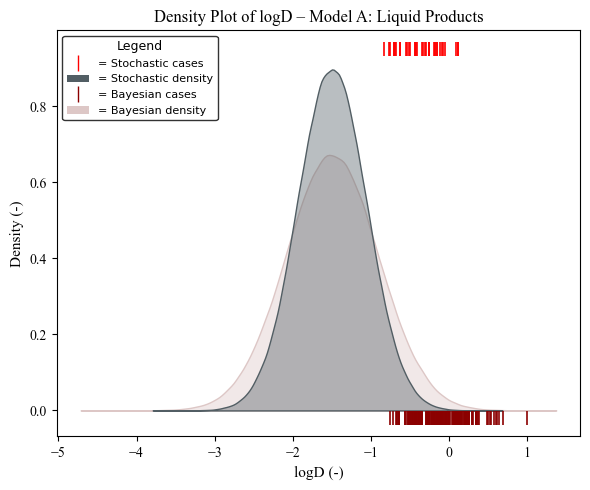

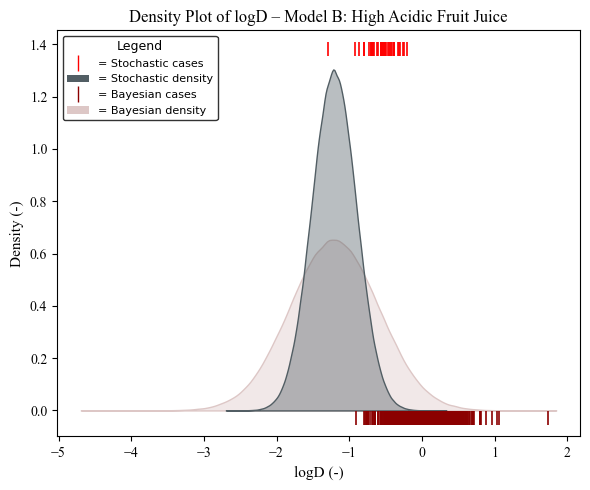

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

def create_density_rug_plot(data, model_name):
    filtered_data = data[
        (data['Model'] == model_name) &
        (data['Scenario'].isin(["Linear model (Stochastic)", "Bayesian model (Probabilistic)"]))
    ]

    stochastic_cases = filtered_data[
        (filtered_data['Scenario'] == "Linear model (Stochastic)") &
        (filtered_data['Ill_binomial'] > 0)
    ]

    bayesian_cases = filtered_data[
        (filtered_data['Scenario'] == "Bayesian model (Probabilistic)") &
        (filtered_data['Ill_binomial'] > 0)
    ]

    scenario_palette = {
        "Linear model (Stochastic)": "#525e64",      # dark gray-blue
        "Bayesian model (Probabilistic)": "#ddc7c6"  # soft gold
    }

    plt.figure(figsize=(6, 5))
    ax = plt.gca()

    # Density plots
    sns.kdeplot(
        data=filtered_data,
        x="logD",
        hue="Scenario",
        fill=True,
        common_norm=False,
        palette=scenario_palette,
        alpha=0.4,
        linewidth=1
    )

    # Barcode (rug) plots
    plt.plot(
        stochastic_cases["logD"], 
        [plt.ylim()[1] * 1.01] * len(stochastic_cases),
        '|', color='red', markersize=10, markeredgewidth=1.2
    )
    plt.plot(
        bayesian_cases["logD"], 
        [plt.ylim()[0] - plt.ylim()[1]*0.02] * len(bayesian_cases),
        '|', color='darkred', markersize=10, markeredgewidth=1.2
    )

    # Axes and labels
    plt.xlabel("logD (-)", fontsize=11, family="Times New Roman")
    plt.ylabel("Density (-)", fontsize=11, family="Times New Roman")
    plt.title(f"Density Plot of logD – {model_name}", fontsize=12, family="Times New Roman")
    plt.xticks(fontsize=10, family="Times New Roman")
    plt.yticks(fontsize=10, family="Times New Roman")
    plt.grid(False)

    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(0.8)
        spine.set_visible(True)

    # Custom legend
    legend_elements = [
        mlines.Line2D([], [], color='red', marker='|', linestyle='None', markersize=12, label='= Stochastic cases'),
        mpatches.Circle((0, 0), radius=5, color=scenario_palette["Linear model (Stochastic)"], label='= Stochastic density', linewidth=0),
        mlines.Line2D([], [], color='darkred', marker='|', linestyle='None', markersize=12, label='= Bayesian cases'),
        mpatches.Circle((0, 0), radius=5, color=scenario_palette["Bayesian model (Probabilistic)"], label='= Bayesian density', linewidth=0)
    ]

    ax.legend(handles=legend_elements, loc="upper left", fontsize=8, frameon=True, edgecolor='black', title="Legend", title_fontsize=9)

    plt.tight_layout()
    plt.show()

# Generate plots
create_density_rug_plot(all_iterations_tp, "Model A: Liquid Products")
create_density_rug_plot(all_iterations_tp, "Model B: High Acidic Fruit Juice")

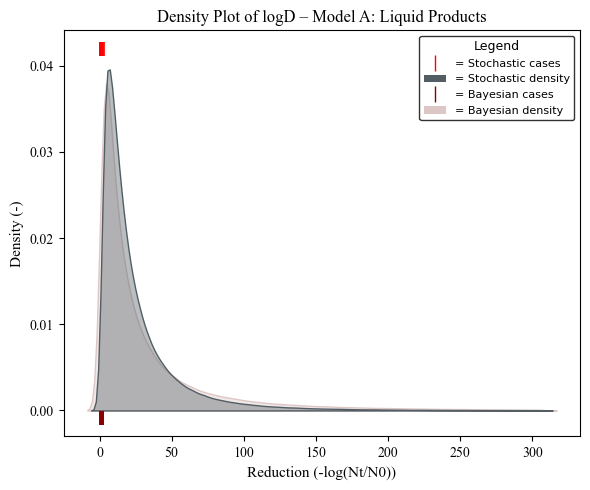

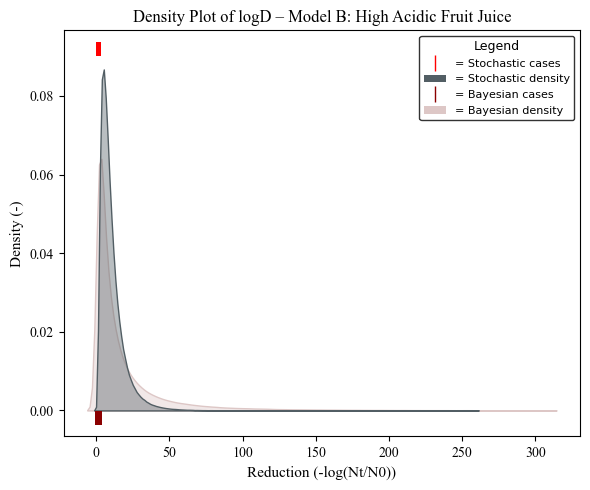

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

def create_density_rug_plot(data, model_name):
    filtered_data = data[
        (data['Model'] == model_name) &
        (data['Scenario'].isin(["Linear model (Stochastic)", "Bayesian model (Probabilistic)"]))
    ]

    stochastic_cases = filtered_data[
        (filtered_data['Scenario'] == "Linear model (Stochastic)") &
        (filtered_data['Ill_binomial'] > 0)
    ]

    bayesian_cases = filtered_data[
        (filtered_data['Scenario'] == "Bayesian model (Probabilistic)") &
        (filtered_data['Ill_binomial'] > 0)
    ]

    scenario_palette = {
        "Linear model (Stochastic)": "#525e64",      # dark gray-blue
        "Bayesian model (Probabilistic)": "#ddc7c6"  # soft gold
    }

    plt.figure(figsize=(6, 5))
    ax = plt.gca()

    # Density plots
    sns.kdeplot(
        data=filtered_data,
        x="Reduction",
        hue="Scenario",
        fill=True,
        common_norm=False,
        palette=scenario_palette,
        alpha=0.4,
        linewidth=1
    )

    # Barcode (rug) plots
    plt.plot(
        stochastic_cases["Reduction"], 
        [plt.ylim()[1] * 1.01] * len(stochastic_cases),
        '|', color='red', markersize=10, markeredgewidth=1.2
    )
    plt.plot(
        bayesian_cases["Reduction"], 
        [plt.ylim()[0] - plt.ylim()[1]*0.02] * len(bayesian_cases),
        '|', color='darkred', markersize=10, markeredgewidth=1.2
    )

    # Axes and labels
    plt.xlabel("Reduction (-log(Nt/N0))", fontsize=11, family="Times New Roman")
    plt.ylabel("Density (-)", fontsize=11, family="Times New Roman")
    plt.title(f"Density Plot of logD – {model_name}", fontsize=12, family="Times New Roman")
    plt.xticks(fontsize=10, family="Times New Roman")
    plt.yticks(fontsize=10, family="Times New Roman")
    plt.grid(False)

    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(0.8)
        spine.set_visible(True)

    # Custom legend
    legend_elements = [
        mlines.Line2D([], [], color='red', marker='|', linestyle='None', markersize=12, label='= Stochastic cases'),
        mpatches.Circle((0, 0), radius=5, color=scenario_palette["Linear model (Stochastic)"], label='= Stochastic density', linewidth=0),
        mlines.Line2D([], [], color='darkred', marker='|', linestyle='None', markersize=12, label='= Bayesian cases'),
        mpatches.Circle((0, 0), radius=5, color=scenario_palette["Bayesian model (Probabilistic)"], label='= Bayesian density', linewidth=0)
    ]

    ax.legend(handles=legend_elements, loc="upper right", fontsize=8, frameon=True, edgecolor='black', title="Legend", title_fontsize=9)

    plt.tight_layout()
    plt.show()

# Generate plots
create_density_rug_plot(all_iterations_tp, "Model A: Liquid Products")
create_density_rug_plot(all_iterations_tp, "Model B: High Acidic Fruit Juice")

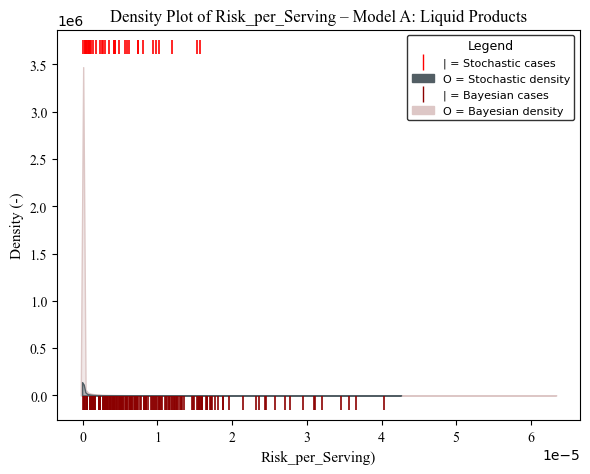

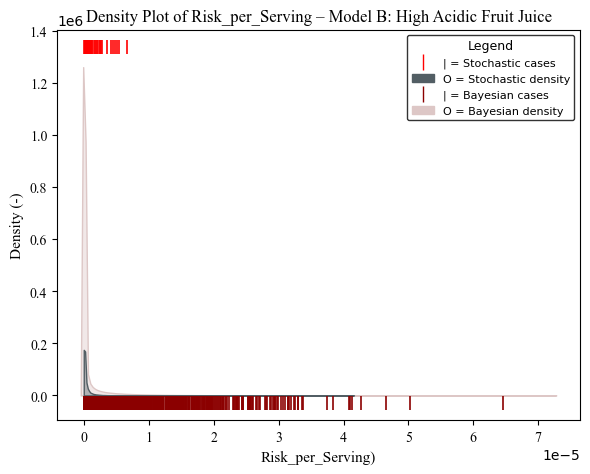

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

def create_density_rug_plot(data, model_name):
    # Filter only relevant model and scenarios
    filtered_data = data[
        (data['Model'] == model_name) &
        (data['Scenario'].isin(["Linear model (Stochastic)", "Bayesian model (Probabilistic)"]))
    ]

    # Identify illness cases for barcode lines
    stochastic_cases = filtered_data[
        (filtered_data['Scenario'] == "Linear model (Stochastic)") &
        (filtered_data['Ill_binomial'] > 0)
    ]

    bayesian_cases = filtered_data[
        (filtered_data['Scenario'] == "Bayesian model (Probabilistic)") &
        (filtered_data['Ill_binomial'] > 0)
    ]

    # Color palette
    scenario_palette = {
        "Linear model (Stochastic)": "#525e64",
        "Bayesian model (Probabilistic)": "#ddc7c6"
    }

    # Start plotting
    plt.figure(figsize=(6, 5))
    ax = plt.gca()

    # KDE plot with correct variable
    sns.kdeplot(
        data=filtered_data,
        x="Risk_per_Serving",  # Use Reduction here!
        hue="Scenario",
        fill=True,
        common_norm=False,
        palette=scenario_palette,
        alpha=0.4,
        linewidth=1
    )

    # Add barcode lines (rug)
    plt.plot(
        stochastic_cases["Risk_per_Serving"],
        [plt.ylim()[1] * 1.01] * len(stochastic_cases),
        '|', color='red', markersize=10, markeredgewidth=1.2
    )
    plt.plot(
        bayesian_cases["Risk_per_Serving"],
        [plt.ylim()[0] - plt.ylim()[1] * 0.02] * len(bayesian_cases),
        '|', color='darkred', markersize=10, markeredgewidth=1.2
    )

    # Axes labels and styles
    plt.xlabel("Risk_per_Serving)", fontsize=11, family="Times New Roman")
    plt.ylabel("Density (-)", fontsize=11, family="Times New Roman")
    plt.title(f"Density Plot of Risk_per_Serving – {model_name}", fontsize=12, family="Times New Roman")
    plt.xticks(fontsize=10, family="Times New Roman")
    plt.yticks(fontsize=10, family="Times New Roman")

    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(0.8)
        spine.set_visible(True)

    # Custom legend
    legend_elements = [
        mlines.Line2D([], [], color='red', marker='|', linestyle='None', markersize=12, label='| = Stochastic cases'),
        mpatches.Patch(color=scenario_palette["Linear model (Stochastic)"], label='O = Stochastic density'),
        mlines.Line2D([], [], color='darkred', marker='|', linestyle='None', markersize=12, label='| = Bayesian cases'),
        mpatches.Patch(color=scenario_palette["Bayesian model (Probabilistic)"], label='O = Bayesian density')
    ]

    ax.legend(handles=legend_elements, loc="upper right", fontsize=8, frameon=True, edgecolor='black', title="Legend", title_fontsize=9)
    plt.tight_layout()
    plt.show()

create_density_rug_plot(all_iterations_tp, "Model A: Liquid Products")
create_density_rug_plot(all_iterations_tp, "Model B: High Acidic Fruit Juice")

## Sensitivity analysis 
A spearmans correlation analysis is performend to assess the sensitivity of the QMRA outputs to the input parameters. It basically assesses the effect of the (variability) in input parameters on the (variability) in the output parameter, which in this case is the probability of illness. The results are visualized in a barchart for both the model based on data for all liquid products and the model based on data for high acidic fruit juices.

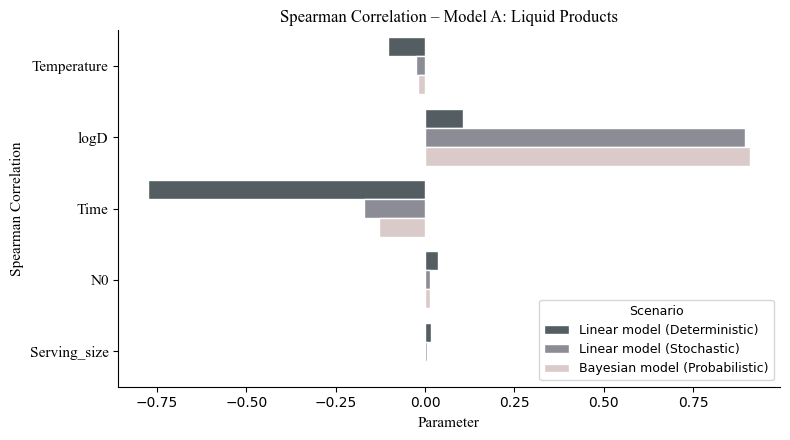

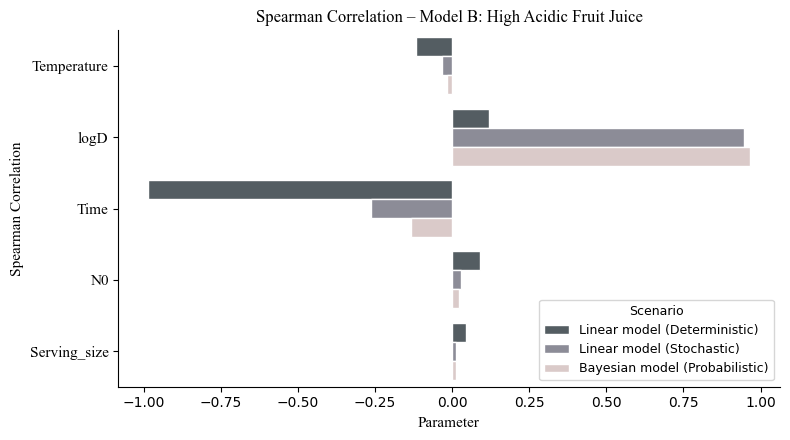

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

# === INPUT: Make sure this contains the required columns ===
df = all_iterations_tp

# === Define parameters to correlate ===
parameters = ["Temperature", "logD", "Time", "N0", "Serving_size"]

# === Calculate Spearman correlation per Model x Scenario x Parameter ===
results = []

for (model, scenario), group in df.groupby(["Model", "Scenario"]):
    if group["Probability_Illness"].std(skipna=True) < 1e-6:
        for param in parameters:
            results.append({
                "Model": model,
                "Scenario": scenario,
                "Parameter": param,
                "Spearman_Correlation": np.nan
            })
        continue

    for param in parameters:
        try:
            valid = group[[param, "Probability_Illness"]].dropna()
            corr, _ = spearmanr(valid[param], valid["Probability_Illness"])
        except Exception:
            corr = np.nan

        results.append({
            "Model": model,
            "Scenario": scenario,
            "Parameter": param,
            "Spearman_Correlation": corr
        })

spearman_df = pd.DataFrame(results)

# === Plotting setup ===
scenario_order = [
    "Linear model (Deterministic)",
    "Linear model (Stochastic)",
    "Bayesian model (Probabilistic)"
]

custom_colors = {
    "Linear model (Deterministic)": "#525e64",
    "Linear model (Stochastic)": "#8a8a99",
    "Bayesian model (Probabilistic)": "#ddc7c6"
}

# === Plotting function ===
def plot_spearman(data, model_title):
    data = data[data["Model"] == model_title].copy()
    data["Scenario"] = pd.Categorical(data["Scenario"], categories=scenario_order, ordered=True)

    plt.figure(figsize=(8, 4.5))
    ax = sns.barplot(
        data=data,
        x="Spearman_Correlation", y="Parameter", hue="Scenario",
        palette=custom_colors, edgecolor="white"
    )
    ax.set_title(f"Spearman Correlation – {model_title}", fontsize=12, family="Times New Roman")
    ax.set_xlabel("Parameter", fontsize=11, family="Times New Roman")
    ax.set_ylabel("Spearman Correlation", fontsize=11, family="Times New Roman")
    ax.invert_yaxis() if data["Spearman_Correlation"].max() < 0 else None
    plt.xticks(rotation=0)
    plt.yticks(fontsize=11, family="Times New Roman")
    plt.legend(title="Scenario", loc="lower right", frameon=True, fontsize=9, title_fontsize=9)
    sns.despine()
    plt.grid(False)
    plt.tight_layout()
    plt.show()

# === Show plots for each model ===
plot_spearman(spearman_df, "Model A: Liquid Products")
plot_spearman(spearman_df, "Model B: High Acidic Fruit Juice")

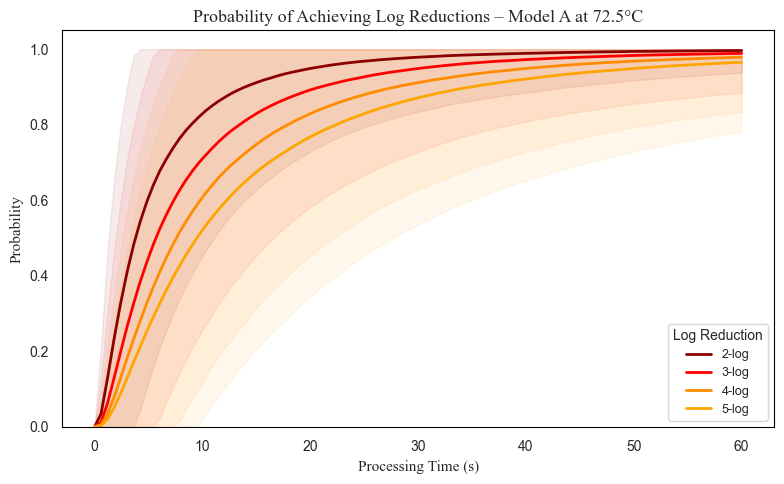

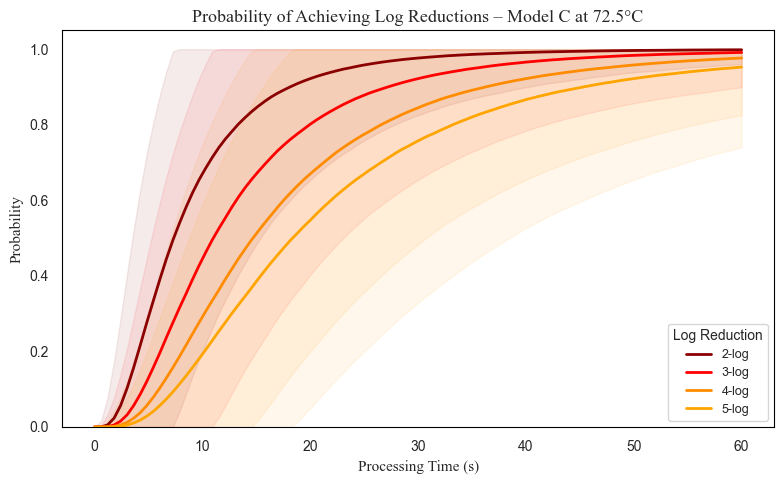

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def compute_combined_probability(time_range, temperature, model_lm, reduction_targets=[2, 3, 4, 5], n_simulations=100000):
    all_results = []

    # Step 1: simulate logD values
    intercept = model_lm['Intercept'].values[0]
    slope = model_lm['Slope'].values[0]
    std_err = model_lm['Standard_Error_Regression'].values[0]

    logD_mean = intercept + slope * temperature
    logD_sim = np.random.normal(loc=logD_mean, scale=std_err, size=n_simulations)
    D_sim = 10**logD_sim

    # Step 2: loop through reduction targets
    for reduction in reduction_targets:
        probs = []
        lowers = []
        uppers = []

        for t in time_range:
            reductions = t / D_sim
            success = reductions >= reduction
            prob = np.mean(success)
            sd = np.std(success)
            lower = max(0, prob - sd)
            upper = min(1, prob + sd)

            probs.append(prob)
            lowers.append(lower)
            uppers.append(upper)

        df = pd.DataFrame({
            'Time': time_range * 60,  # convert to seconds
            'Probability': probs,
            'Lower': lowers,
            'Upper': uppers,
            'Reduction_Target': str(reduction)
        })
        all_results.append(df)

    return pd.concat(all_results, ignore_index=True)

def plot_combined_probabilities(prob_data, model_name):
    color_map = {
        "2": "darkred",
        "3": "red",
        "4": "darkorange",
        "5": "orange"
    }

    fig, ax = plt.subplots(figsize=(8, 5))

    for red in ["2", "3", "4", "5"]:
        subset = prob_data[prob_data["Reduction_Target"] == red]
        ax.plot(subset["Time"], subset["Probability"], label=f"{red}-log", color=color_map[red], linewidth=2)
        ax.fill_between(subset["Time"], subset["Lower"], subset["Upper"], color=color_map[red], alpha=0.08)

    ax.set_xlabel("Processing Time (s)", fontsize=11, family="Times New Roman")
    ax.set_ylabel("Probability", fontsize=11, family="Times New Roman")
    ax.set_title(f"Probability of Achieving Log Reductions – {model_name}", fontsize=13, family="Times New Roman")

    ax.tick_params(axis='both', labelsize=10)
    ax.legend(title="Log Reduction", title_fontsize=10, fontsize=9)
    ax.set_ylim(0, 1.05)
    ax.grid(False)
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(0.8)
    plt.tight_layout()
    plt.show()

# Define time in minutes
time_range = np.linspace(0, 1, 100)  # 0 to 1 minute
temperature = 72  # example

# Use your fitted models
model_lm_A = results_lm_A['regression_coefficients']
model_lm_C = results_lm_C['regression_coefficients']

# Compute probability curves
combined_prob_A = compute_combined_probability(time_range, temperature, model_lm_A)
combined_prob_C = compute_combined_probability(time_range, temperature, model_lm_C)

# Plot the results
plot_combined_probabilities(combined_prob_A, "Model A at 72.5°C")
plot_combined_probabilities(combined_prob_C, "Model C at 72.5°C")


In [66]:
safe_risk_bay = (
    all_iterations_tp[all_iterations_tp['Scenario'] == "Bayesian model (Probabilistic)"]
    .sort_values(['Model', 'Risk_per_Serving'])
    .groupby('Model')
    .apply(lambda g: g.loc[g['Ill_binomial'].idxmax() - 1, 'Risk_per_Serving']
           if g['Ill_binomial'].any() and g['Ill_binomial'].idxmax() > g.index.min()
           else np.nan)
    .reset_index(name='Safe_Risk')
)

safe_risk_st = (
    all_iterations_tp[all_iterations_tp['Scenario'] == "Linear model (Stochastic)"]
    .sort_values(['Model', 'Risk_per_Serving'])
    .groupby('Model')
    .apply(lambda g: g.loc[g['Ill_binomial'].idxmax() - 1, 'Risk_per_Serving']
           if g['Ill_binomial'].any() and g['Ill_binomial'].idxmax() > g.index.min()
           else np.nan)
    .reset_index(name='Safe_Risk')
)
safe_logD_st = (
    all_iterations_tp[all_iterations_tp['Scenario'] == "Linear model (Stochastic)"]
    .sort_values(['Model', 'logD'])
    .groupby('Model')
    .apply(lambda g: g.loc[g['Ill_binomial'].idxmax() - 1, 'logD']
           if g['Ill_binomial'].any() and g['Ill_binomial'].idxmax() > g.index.min()
           else np.nan)
    .reset_index(name='Safe_logD')
)

safe_reduction_st = (
    all_iterations_tp[all_iterations_tp['Scenario'] == "Linear model (Stochastic)"]
    .sort_values(['Model', 'Reduction'])
    .groupby('Model')
    .apply(lambda g: g.loc[g['Ill_binomial'].idxmax() - 1, 'Reduction']
           if g['Ill_binomial'].any() and g['Ill_binomial'].idxmax() > g.index.min()
           else np.nan)
    .reset_index(name='Safe_Reduction')
)

safe_reduction_bay = (
    all_iterations_tp[all_iterations_tp['Scenario'] == "Bayesian model (Probabilistic)"]
    .sort_values(['Model', 'Reduction'])
    .groupby('Model')
    .apply(lambda g: g.loc[g['Ill_binomial'].idxmax() - 1, 'Reduction']
           if g['Ill_binomial'].any() and g['Ill_binomial'].idxmax() > g.index.min()
           else np.nan)
    .reset_index(name='Safe_Reduction')
)

print("\n--- Safe Risk (Bayesian) ---")
print(safe_risk_bay)

print("\n--- Safe Risk (Stochastic) ---")
print(safe_risk_st)

print("\n--- Safe logD (Stochastic) ---")
print(safe_logD_st)

print("\n--- Safe Reduction (Stochastic) ---")
print(safe_reduction_st)

print("\n--- Safe Reduction (Bayesian) ---")
print(safe_reduction_bay)

/var/folders/kn/y01l9gy569n9xw0md1_jsd480000gn/T/ipykernel_12095/1834619869.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.loc[g['Ill_binomial'].idxmax() - 1, 'Risk_per_Serving']
/var/folders/kn/y01l9gy569n9xw0md1_jsd480000gn/T/ipykernel_12095/1834619869.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.loc[g['Ill_binomial'].idxmax() - 1, 'Risk_per_Serving']
/va


--- Safe Risk (Bayesian) ---
                              Model     Safe_Risk
0          Model A: Liquid Products  1.037794e-09
1  Model B: High Acidic Fruit Juice  2.886580e-19

--- Safe Risk (Stochastic) ---
                              Model     Safe_Risk
0          Model A: Liquid Products  2.886580e-19
1  Model B: High Acidic Fruit Juice  8.893787e-10

--- Safe logD (Stochastic) ---
                              Model  Safe_logD
0          Model A: Liquid Products  -1.606535
1  Model B: High Acidic Fruit Juice  -1.297387

--- Safe Reduction (Stochastic) ---
                              Model  Safe_Reduction
0          Model A: Liquid Products        4.841883
1  Model B: High Acidic Fruit Juice       22.267197

--- Safe Reduction (Bayesian) ---
                              Model  Safe_Reduction
0          Model A: Liquid Products       31.406103
1  Model B: High Acidic Fruit Juice        7.626734


/var/folders/kn/y01l9gy569n9xw0md1_jsd480000gn/T/ipykernel_12095/1834619869.py:44: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.loc[g['Ill_binomial'].idxmax() - 1, 'Reduction']
